In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

In [5]:
import feather
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import metrics


 # Hello lesson 3
 - interpretation of random forests.
 - getting insights
 - profiling
 - loading and processing very big data
 - feature importance 
 - and fun...
 

## The first point of the lecture is the "schema"
- the star schema or the snowflake schema.


In [6]:
df_raw = feather.read_dataframe("tmp/mybulldozer-raw")

## feather format is a really important feature for saving and then retrieving your data very fast. Make sure to use it.

In [13]:
#df_raw.loc[df_raw['YearMade'] == 1000,'YearMade'] = 1930


In [14]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


## IMPORTANT POINT RELATED TO THE proc_df function.
- proc_df function replaces the missing values with the medians of that column and replaces the categorical variables with there codes which were acquired from the train_cats function.


- Now, it can be so that test data set has missing values in the columns that are not in the training set and thus you would not really have a column in your test data set and thus it would give an error.
- Problem 2 is that the median of the numeric values may be different in the test set than the training set.
- proc_df returns three things->
- third is the "nas" which is a dictionary with the key,value pairs where keys are the missing column names and the values are the medians of athe numeric values in the actual column.
- <b> pass the same variable name in na_dict and the return parameter</b>


 #### You can pass this 'nas' column in the test set so that it processes the test dataset same as the training set.
 ## Syntax-
 - proc_df(dataframe, dependent_var, subset=None, na_dict = name_of_na_dict)

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
df_raw.corr().transpose()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
SalesID,1.000000,-0.001625,0.286812,0.150199,0.788917,-0.021582,0.001701,0.004565,0.437553,0.121679,...,0.017943,-0.107666,0.123481,-0.004661,-0.025702,0.019013,-0.009433,-0.001327,NaN,0.443365
SalePrice,-0.001625,1.000000,-0.222141,-0.114256,0.007734,-0.054279,0.182514,0.013867,0.030166,-0.028842,...,-0.002533,-0.061231,-0.029092,0.007916,-0.007235,0.006397,-0.008652,0.001609,NaN,0.028712
MachineID,0.286812,-0.222141,1.000000,0.160591,0.327118,0.007548,-0.060384,-0.004128,0.051761,0.035245,...,0.000008,-0.028508,0.035290,-0.013184,-0.006070,-0.004801,-0.008244,-0.001654,NaN,0.053465
ModelID,0.150199,-0.114256,0.160591,1.000000,0.091757,-0.019982,-0.049762,-0.005781,0.139346,0.007542,...,0.006178,-0.002535,0.008089,0.002961,-0.007153,0.004348,-0.001567,-0.001463,NaN,0.139664
datasource,0.788917,0.007734,0.327118,0.091757,1.000000,-0.018795,0.067088,0.006475,0.319850,0.063777,...,-0.000403,-0.133594,0.063588,-0.007044,-0.015213,0.013223,-0.012075,-0.002408,NaN,0.322791
auctioneerID,-0.021582,-0.054279,0.007548,-0.019982,-0.018795,1.000000,-0.017644,0.033179,-0.066729,0.017425,...,-0.019248,0.106498,0.015547,-0.012703,0.001707,-0.014135,-0.006115,-0.000339,NaN,-0.065940
YearMade,0.001701,0.182514,-0.060384,-0.049762,0.067088,-0.017644,1.000000,-0.011733,-0.044084,0.017811,...,-0.010348,-0.045306,0.017178,0.002031,0.009435,-0.001904,0.006107,0.000573,NaN,-0.043213
MachineHoursCurrentMeter,0.004565,0.013867,-0.004128,-0.005781,0.006475,0.033179,-0.011733,1.000000,0.025886,-0.025287,...,-0.002930,0.032744,-0.026134,-0.010088,0.027515,-0.004755,-0.005872,0.000061,NaN,0.023057
saleYear,0.437553,0.030166,0.051761,0.139346,0.319850,-0.066729,-0.044084,0.025886,1.000000,-0.014792,...,0.032411,-0.074636,-0.012390,0.012878,-0.042325,0.029457,-0.000966,0.001346,NaN,0.998787
saleMonth,0.121679,-0.028842,0.035245,0.007542,0.063777,0.017425,0.017811,-0.025287,-0.014792,1.000000,...,-0.124482,0.036912,0.996782,-0.070551,0.028325,-0.017470,0.028859,0.002579,NaN,0.034298


In [7]:
# let's see here-
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')


## Another update on proc_df
- When subset= some INT is passed as a parameter, then proc_df returns the last INT rows of the dataframe.
- Important in time series analysis.


In [9]:
df_trn.describe(include='all')

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
count,4.011250e+05,4.011250e+05,401125.000000,401125.000000,401125.000000,401125.000000,4.011250e+05,401125.000000,401125.000000,401125.000000,...,401125.000000,401125,401125,401125,401125,401125,401125,4.011250e+05,401125,401125
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,2,2,2,2,1,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,False,False,NaN,False,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,387586,390968,394985,398606,401124,401125,NaN,380989,258360
mean,1.919713e+06,1.217903e+06,6889.702980,134.665810,6.327332,1899.156901,1.230726e+03,0.376102,1673.709485,559.165442,...,179.977581,NaN,NaN,NaN,NaN,NaN,NaN,1.091433e+09,NaN,NaN
std,9.090215e+05,4.409920e+05,6221.777842,8.962237,16.575066,291.797469,1.654290e+04,0.870291,1263.331163,469.310266,...,103.559930,NaN,NaN,NaN,NaN,NaN,NaN,1.816977e+08,NaN,NaN
min,1.139246e+06,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,0.000000,1.000000,1.000000,...,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.009984e+08,NaN,NaN
25%,1.418371e+06,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00,0.000000,631.000000,206.000000,...,84.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.708768e+08,NaN,NaN
50%,1.639422e+06,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00,0.000000,1395.000000,406.000000,...,168.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.143072e+09,NaN,NaN
75%,2.242707e+06,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,0.000000e+00,0.000000,2292.000000,704.000000,...,271.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.237853e+09,NaN,NaN


In [8]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000 # last 
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## PROFILING
- When we run a certain code takes a lot of time to run just simply run a profiler function which gives you the time distribution of different subtasks in the code.
- the magic function %prun is used for the profiling of the function.
- for example-

In [13]:
m= RandomForestRegressor(n_estimators=40, min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
# what %prun does is that it will tell you which
# lines of code took the most time.
# here it is acquire method. Can't really do anything 
# about it.
#%prun m.fit(df_trn,y_trn) 

In [13]:
df_trn.tail()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
401120,6333336,1840702,21439,149,1.0,2005,0.0,0,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401121,6333337,1830472,21439,149,1.0,2005,0.0,0,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401122,6333338,1887659,21439,149,1.0,2005,0.0,0,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401123,6333341,1903570,21435,149,2.0,2005,0.0,0,483,159,...,298,False,False,False,False,False,False,1319500800,False,True
401124,6333342,1926965,21435,149,2.0,2005,0.0,0,483,159,...,298,False,False,False,False,False,False,1319500800,False,True


### CONFIDENCE OF PREDICTION
- We would be less confident of a prediction if we haven't seen that kind of row before and so we do not have a path desgined in the RF to really predict the value for that row. 
- So you would expect that when we pass this unusual row of data through the trees then the variation in the predictions is <b> HIGH </b> meaning the <b> STANDARD DEVIATION OF PREDICTIONS</b> is high.

- So <b> Standard Deviation of Predictions </b> gives us a kind of a relative understanding of how confident we are of a prediction.


In [14]:
set_rf_samples(50000)

In [14]:
%time m.fit(X_train,y_train)

CPU times: user 4min 34s, sys: 2.28 s, total: 4min 36s
Wall time: 41.1 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [17]:
print_score(m)

[0.11913010818939014, 0.2272022988479403, 0.9703395388856764, 0.9078122073026695, 0.9117628499652166]


## Now, we need just like the last lesson the stack of predictions for each row across each tree.
## use list comprehension.
- np.stack concatenates the results of the trees for a row in a list and has multiple lists 

In [18]:
%time preds = np.stack(t.predict(X_valid) for t in m.estimators_)

CPU times: user 2.26 s, sys: 63.4 ms, total: 2.32 s
Wall time: 2.33 s


In [19]:
len(preds)

40

In [20]:
preds[:,1] # meaning
# means for row number '1' these are 
# the results of all the trees in the 
# model.
# Note that this is the second column in the stack of 40 trees' values and thus gives the prediction for the 
# second row in the actual dataset.

array([9.51594, 9.08856, 9.11999, 9.44736, 9.51817, 9.25119, 9.14102, 9.27283, 8.9405 , 9.16626, 9.08231,
       8.99055, 9.23338, 9.09813, 9.39216, 9.04511, 9.14056, 9.45447, 9.03326, 9.55471, 8.98524, 9.805  ,
       9.06951, 9.03954, 9.19446, 9.08815, 9.12661, 9.24517, 9.02646, 9.20971, 9.14173, 9.2451 , 9.09438,
       9.54442, 9.12752, 9.34815, 9.11642, 9.00866, 9.41311, 9.37932])

In [21]:
print("Mean",np.mean(preds[:,0]),"SD:",np.std(preds[:,0]))

Mean 9.178754747879392 SD: 0.15057065983168627


## PARALLEL TREES
- now this list comprehension can be slow as it is a serial operation meaning that it runs only on a single core of the CPU.
- HOW TO SPEED UP?
- Use parallel_trees() function of the fastai library that takes in two parameters- the first is the model and the second is the function which calls upon the model's trees' predictions. 

In [21]:
??parallel_trees

Signature: parallel_trees(m, fn, n_jobs=8)
Docstring: <no docstring>
Source:   
def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))
File:      /notebooks/fastai/structured.py
Type:      function


In [22]:
#so now i write a function get_estimator
def get_estimator(t):
    return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m,get_estimator))
# you don't pass the parameters when 
# you pass the function into another function.
print("Mean",np.mean(preds[:,0]),"SD:",np.std(preds[:,0]))

CPU times: user 507 ms, sys: 423 ms, total: 930 ms
Wall time: 1.38 s
Mean 9.178754747879392 SD: 0.15057065983168627


In [23]:
#the wall time and cpu time has surely
# gone down.

In [24]:
x = raw_valid.copy()
x.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
389125,4364751,9.104980,2300944,665,172,1.0,1999,3726.0,Low,KX1212,...,16,3,259,False,False,False,False,False,False,1284595200
389126,4364757,9.047821,1265434,12042,172,1.0,1996,5809.0,Low,KX151,...,9,3,343,False,False,False,False,False,False,1291852800
389127,4364774,9.104980,2005935,9218,172,1.0,1993,0.0,NaN,KX41,...,6,4,218,False,False,False,False,False,False,1281052800
389128,4364807,9.259131,2296707,668,172,1.0,2000,1789.0,Low,KX612,...,15,2,349,False,False,False,False,False,False,1292371200
389129,4364811,9.104980,1403366,9219,172,1.0,1999,0.0,NaN,KX61,...,10,2,161,False,False,False,False,False,False,1244592000


- let us now add the mean and the standard deviations of the predictions in the copied data set.

In [25]:
x["preds_mean"] = np.mean(preds,axis=0)
x["preds_std"] = np.std(preds,axis=0)

In [ ]:
x.head()

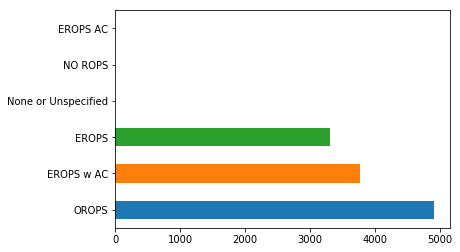

In [27]:
x.Enclosure.value_counts().plot.barh()

In [28]:
fld = ["Enclosure","SalePrice","preds_mean","preds_std"] 
enc_summary = x[fld].groupby("Enclosure",as_index = False).mean() 
enc_summary

,Enclosure,SalePrice,preds_mean,preds_std
0,EROPS,9.849178,9.845488,0.271443
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.577112,0.265684
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.688057,0.223017


## Don't care about the eropsAC and other categories which have no values in them.
## A really good insight comes from here that ->
- the categories which have a larger number of values in them have a good prediction SD means since the model has been trained with a larger number of values, it can handle a larger amount of varation and hence produces lesser standard deviation.


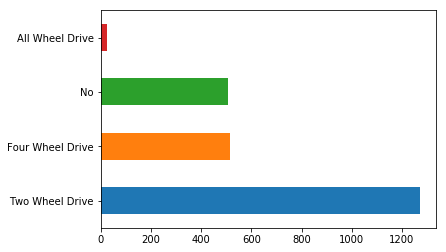

In [29]:
x.Drive_System.value_counts().plot.barh()

## these plots show the value counts of the categories of the datasets.
## now you can make separate dataframes and look at different SD and means of the predicted values.

In [30]:
flds = ['Drive_System','SalePrice','preds_mean','preds_std']
drive_summ = x[flds].groupby('Drive_System').mean()
drive_summ

,SalePrice,preds_mean,preds_std
Drive_System,,,
All Wheel Drive,11.366583,11.239575,0.288103
Four Wheel Drive,10.037591,10.006275,0.180915
No,10.634809,10.623309,0.270142
Two Wheel Drive,9.860618,9.858901,0.191106


In [31]:
(drive_summ.preds_std/drive_summ.preds_mean).sort_values(ascending=False)     

Drive_System
All Wheel Drive     0.025633
No                  0.025429
Two Wheel Drive     0.019384
Four Wheel Drive    0.018080
dtype: float64

## The Insight-> 
- this ratio shows us that the predictions are less accurate when SD is high.
- Also a better measure would be SD/mean which shows that how a features predictions are accurate or not.

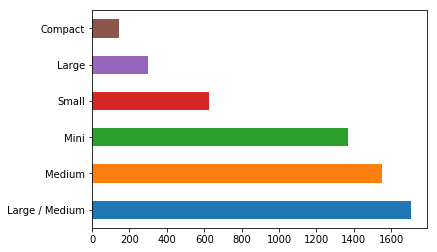

In [32]:
raw_valid.ProductSize.value_counts().plot.barh()

In [33]:
field = ['ProductSize','SalePrice','preds_mean','preds_std']
Size_summ = x[field].groupby(field[0]).mean()

In [34]:
Size_summ

,SalePrice,preds_mean,preds_std
ProductSize,,,
Compact,9.735093,9.866034,0.337570
Large,10.470589,10.386116,0.365938
Large / Medium,10.691871,10.651631,0.300158
Medium,10.681511,10.624804,0.287473
Mini,9.535147,9.567708,0.248862
Small,10.324448,10.316399,0.302840


In [35]:
(Size_summ.preds_std/Size_summ.preds_mean).sort_values()

ProductSize
Mini              0.026011
Medium            0.027057
Large / Medium    0.028180
Small             0.029355
Compact           0.034215
Large             0.035233
dtype: float64

## The insight hidden here is again that since product_size large and compact are smallest groups, the predictions for those groups are not really good as there Standard Deviation is high.

 # <u><i> Feature Importance </i></u>
 - It is not normally enough to know that our model can make predictions- we also want to know how it is making them.

In [26]:
fi = rf_feat_importance(m,df_trn)
fi[:15]

,cols,imp
5,YearMade,0.169935
37,Coupler_System,0.141182
13,ProductSize,0.095190
14,fiProductClassDesc,0.080810
2,ModelID,0.058109
63,saleElapsed,0.054072
10,fiSecondaryDesc,0.047738
19,Enclosure,0.039558
8,fiModelDesc,0.035620
38,Grouser_Tracks,0.033509


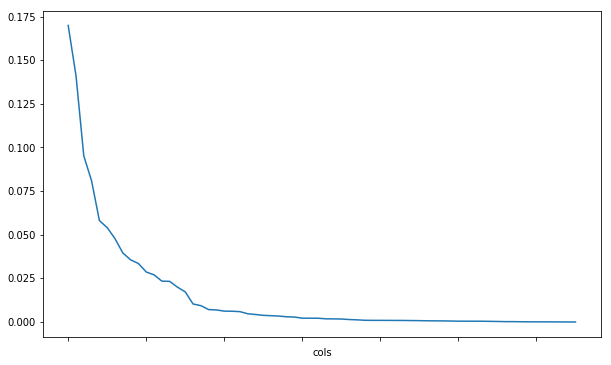

In [27]:
fi.plot('cols','imp',figsize=(10,6),legend= False)

In [38]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

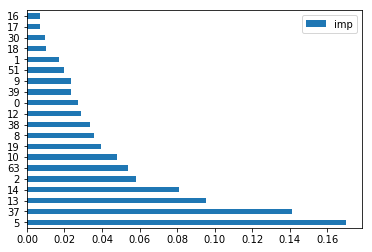

In [28]:
fi[:20].plot.barh()
# it essentially gives you the same shape

## This shows that some columns are really important and some aren't.
- This means that you can focus on the first 10-20 columns and learn about them and not really care about the others because they do not matter here. 

- What to do with it? 
- Yearmade is the most important feature here. So you sit down and search everything about yearmade, you look at scatter plots of year made vs saleprice and how which year has the most sales etc.

- It can even be the fact that a feature that you consider very important according to your model will sometimes not make sense in real life. 
- It doesn't mean the model is wrong but that your client or the source does not have a very good understanding of your data.

## DATA LEAKAGE
- It basically means that you are modelling with some data that the source did not have at the time they were making a decision.
## JEREMY's Example
- He enetered in a competition where he had to predict whether a grant application was accepted or not. When he plotted the feature importance for the columns given, he found that whether the column was missing or not was actually telling him that the grant was accepted or not. 
- This is because had the grant been accepted, the column would have been filled up.

<b>Data leakage</b> means there is information in the dataset that I was modeling with which the university would not have had in real life at that point in time they were making a decision. When they are actually deciding which grant applications to prioritize, they do not know which ones the admin staff will later on going to add information to because it turns out that they were accepted.

## Go through the top twenty atleast.
- Now set up a  threshold to include the columns with feature importance above it like 0.005 .


In [29]:
to_keep = fi[fi.imp > 0.005].cols

In [30]:
len(to_keep)

23

### Make a new df which has those columns and then again split in validation and training sets.

In [68]:
df_keep = df_trn[to_keep]
X_train, X_valid= split_vals(df_keep,n_trn)

In [32]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.12464385647172847, 0.22520167689658685, 0.9675304267096435, 0.9094285722233146, 0.9102810263350822]


## We observe that r^2 didn't change very much for our model. 
- Note - if it is going down, then the columns you left out weren't redundant after all.


In [33]:
?rf_feat_importance


Signature: rf_feat_importance(m, df)
Docstring: <no docstring>
File:      /notebooks/fastai/structured.py
Type:      function


In [52]:
fi = rf_feat_importance(m,df_keep)
fi

,cols,imp
0,YearMade,0.174938
2,ProductSize,0.105534
1,Coupler_System,0.101336
3,fiProductClassDesc,0.086530
4,ModelID,0.061505
5,Grouser_Tracks,0.057062
6,saleElapsed,0.053373
8,fiSecondaryDesc,0.044731
10,Enclosure,0.038569
9,fiModelDesc,0.036958


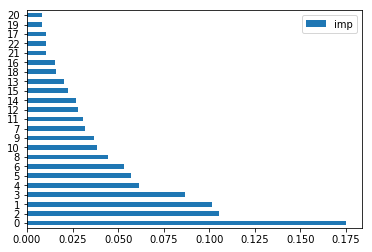

In [45]:
fi.plot.barh()

- After you have only included the columns you wanted in the dataframe you will see your plot will become clearer. Why is that?
- Because you may well be removing the collinearity in the dataset.
- At first it may be like that year made and one other column is like having divided importance okay.
- But when you remove those <b> redundant</b> columns you get that yearmade is a really important feature in determining your predictions. 

# How is feature importance actually calculated and what it is?
- It is a technique you can use for any machine learning model.
- We take our dataset.
- we have our saleprice column.
- and we have our other 25 independent variables.
- how do you calculate feature importance?
- You <b>take one independent variable column</b> , let's say yearmade.
- You take the RF and predict the dependent variable and then calculate the rmse and r^2 and then.....->
- <b> Take the year_made column and randomly shuffle it</b>. After you shuffle yearmade you will have no relation between the dependent variable and the yearmade.
- Now again you calculate the predictions, calculate the rmse and the r^2 and then see that how different it is from the original one.
- The difference in the actual r^2 and the random shuffle r^2 is actuall y the feature importance.
- When you take another variable <b> you put the old variable as it was </b> and then randomly shuffle the new variable and do the same procedure again.


## NOTE -
- you should not remove the column and then test for the importance as it would be very slow.
- why? because you will have to train a new random forest for each column removed.

In [46]:
cols= ['YearMade','SalePrice']
year_price = df_raw[:50000][cols]

In [57]:
year_1000= year_price.loc[year_price['YearMade'] == 1000]

In [58]:
year_1000[year_1000['SalePrice'] > 9.5].count()

YearMade     4080
SalePrice    4080
dtype: int64

In [59]:
(year_price['SalePrice'].describe())

count    50000.000000
mean         9.941447
std          0.665176
min          8.465900
25%          9.433484
50%          9.878170
75%         10.373491
max         11.863582
Name: SalePrice, dtype: float64

In [60]:
new_one = year_price[year_price["YearMade"] > 1000 ]
new_one['YearMade'].describe()

count    44034.000000
mean      1995.842622
std          8.118020
min       1919.000000
25%       1990.000000
50%       1997.000000
75%       2002.000000
max       2010.000000
Name: YearMade, dtype: float64

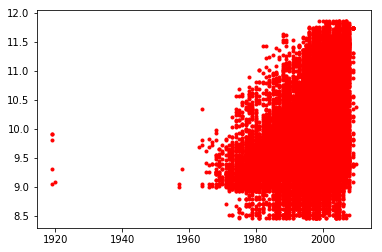

In [61]:
plt.scatter(new_one['YearMade'],new_one['SalePrice'],marker = '.',color = 'r')

### This is something that I found out with respect to the yearmade and yeah it is strange that a bulldozer has a manufacturing of 1000 ,lol.

In [62]:
df_trn.loc[df_raw['YearMade'] == 1000,'YearMade'] = 1940
X_train.loc[df_raw['YearMade'] == 1000,'YearMade'] = 1940
X_valid.loc[df_raw['YearMade'] == 1000,'YearMade'] = 1940

/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
m.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [64]:
print_score(m)

[0.2068022042290639, 0.24420702373675773, 0.9106190115893028, 0.8934964030657786, 0.8942534490655115]


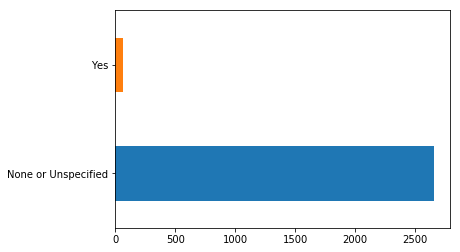

In [47]:
x.Coupler_System.value_counts().plot.barh()

In [84]:
x.Coupler_System.head()

389125    NaN
389126    NaN
389127    NaN
389128    NaN
389129    NaN
Name: Coupler_System, dtype: category
Categories (2, object): [None or Unspecified < Yes]

In [90]:
couple = (x.loc[ x['Coupler_System']!= 'None or Unspecified' ])
couple = couple.loc[couple['Coupler_System']!='Yes']

In [98]:
columns = ['Coupler_System','SalePrice','preds_mean','preds_std']
couple_summ = couple[columns]#.groupby('Coupler_System').mean()
couple_summ.preds_std.mean()

0.2653304064806766

- the above analysis just showed that the coupler system where the value was missing had the worst predictions amongst the three values.

In [97]:
columns = ['Coupler_System','SalePrice','preds_mean','preds_std']
couple_summ = x[columns].groupby('Coupler_System').mean()
couple_summ

,SalePrice,preds_mean,preds_std
Coupler_System,,,
None or Unspecified,9.253847,9.262917,0.206878
Yes,9.327597,9.313870,0.210265


# HELLO LESSON 4


- The first part of the lesson just talked extensively about the tuning of the hyperparameters and the meaning of oob and bootstrapping.
- The definitions are written in the my_lesson1 and 2 notebook you can look there whenever you like.
- The lesson really starts from the one- hot encoding part.

## Validation set anomalies or bad validation scores-
- Maybe you validation set has a particular different set of features than your actual training data model and thus they are not being accounted for.
- Or that you are overfitting. In that case oob will also get worse.In Random forests case we don't really overfit that much.

## A wrong way to calculate feature importance.
- You can say that if you have r columns then for your dataset you can write-
ax1+bx2+cx3+... = y.
- Then a,b,c ... are the importance of the variables x1,x2,x3... .
- This is wrong because this would obviously be missing interactcion between variables. 
- You should be sceptical when you hear this out. 

# ONE HOT ENCODING
proc_df's optional **max_n_cat** argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.
Each of the new columns would be a boolean column , true at each row where the category was present.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

## proc_df(df, dependent var, max_n_cats) 
- **max_n_cats** tells the proc_df function to convert a categorical variable to be one hot encoded with no of categories less than max_n_cats.

- In one point if we do not want the **ordinal variable** values to be one hot encoded as we actually have some mathematical meaning in that variable.
eg. [high,low,medium] = [3,1,2] is actually good .
### How to avoid?
- change the column to the categories **before passing to the proc_df** function. 
- eg . df.UsageBand = df.UsageBand.cat.codes.
- so, proc_df doesn't look at it.

In [ ]:
df_trn2, y, nas = proc_df(df_raw, 'SalePrice',max_n_cat=7)
X_train, X_valid = split_vals(df_trn2,n_trn)

model = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
model.fit(X_train,y_train)
# an error was coming because print_score
# contains global variables in the definition
# that are X_train and X_valid.
print_score(model)

In [ ]:
fi = rf_feat_importance(model,df_trn2)
fi[:15]

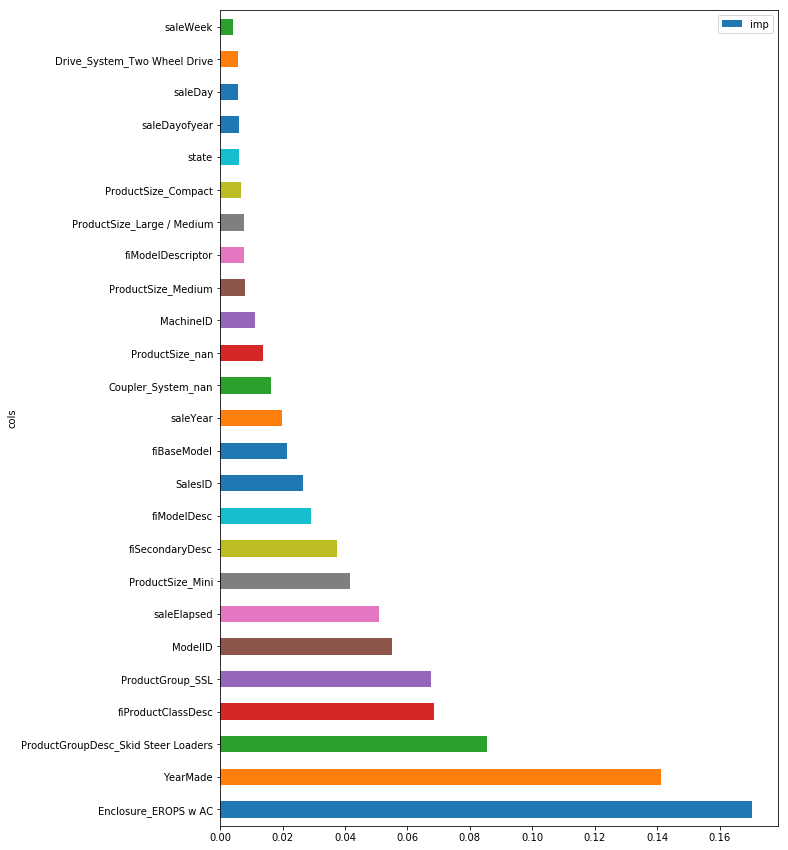

In [13]:
(fi[:25]).plot('cols','imp','barh',figsize=(10,15))

## a new insight.
- a category **erops w AC** is now the most important defining category.
- now I need to find out what the Enclosure with AC means because it is so importantttttt.

In [53]:
keeping = fi[fi['imp'] > 0.007].cols

In [55]:
#keeping

## Dendogram. 
- **GOAL**- **REMOVING REDUNDANT FATURES**
- To look for the redundant variables.
- This is a kind of a cluster analysis. 
- Heirarchical clustering ->
- You look at every pair of objects and look which are closest. 
- We find that, and replace them wih their mid-points.
- And instead of looking at the points look at the **variables**.
- and then combine them.

- Here the basis of correlation between the variables was **spearman's rank correlation**
- Why? RandomForests do not consider the linearity between the data and if you had pearson's correlation it assumes linearity.
- Spearman's correlation just gives you the corresponding ranks of the data and then plots them with axes that represent ranks .
- note **the function has to be monotonic**

In [57]:
from scipy.cluster import hierarchy as hc

- Note that we **do not do this on one-hot encoded variables** as we want to look at the relation between the features of the data not the categories of the features.

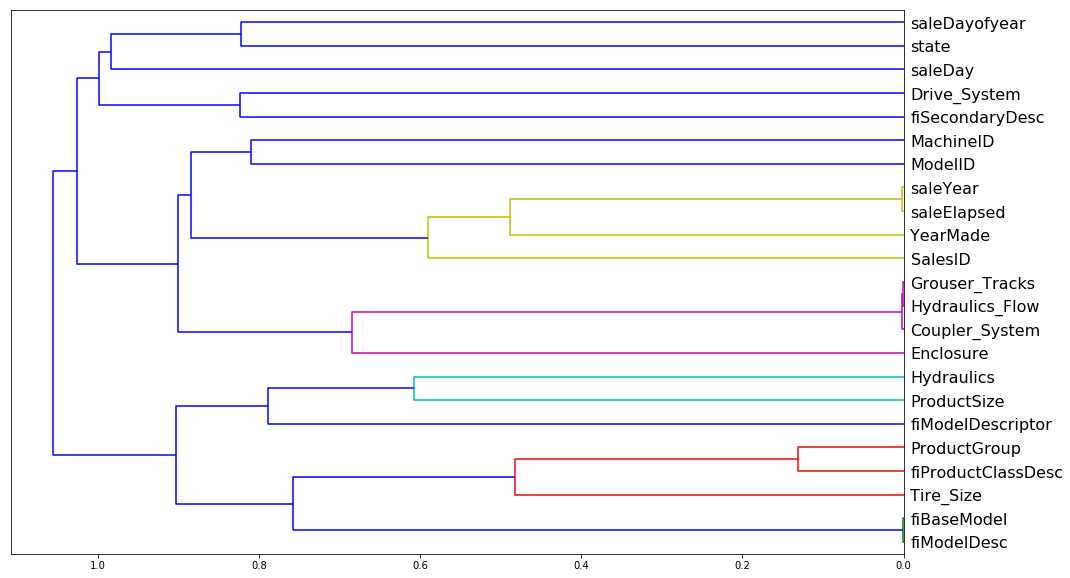

In [59]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
# spearman correlation.
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
# the above steps are standard and you can look at the code 
# whenever you plot it.
plt.show()

- According to the dendogram which are related on the right means they are related wrt the ranks.
- So, **saleyear and saleelapsed** seem to be measuring the same things.
- So do **fibasemodel and fimodeldesc**

- **ANALYSIS** 
- Let us try and remove the features one by one which seem redundant and calculate the oob score for our data.
- **note** don't remove all of them, just one of each kind .

In [69]:
def get_oob(df):
    x,_ = split_vals(df,n_trn)
    m = RandomForestRegressor(n_estimators=30,min_samples_leaf=4,max_features=0.5,n_jobs=-1,oob_score=True)
    m.fit(x,y_train)
    return m.oob_score_

In [72]:
remove = ['saleYear','Grouser_Tracks','Coupler_System','ProductGroup','fiBaseModel']
# dropping each column and finding the 
# oob_score after that.
for f in remove:
    print(f,get_oob(df_keep.drop(f,axis=1)))

saleYear 0.8898086753845976
Grouser_Tracks 0.8914054400300047
Coupler_System 0.8911750873835337
ProductGroup 0.8918035336598038
fiBaseModel 0.8903765334143052


In [71]:
 print('saleElapsed',get_oob(df_keep.drop('saleElapsed',axis=1)))

saleElapsed 0.8872514394343485


# PARTIAL DEPENDENCE PLOTS.
- Basis of these plots is that we choose a variable and then look how the dependent variable varies with that variable when all other values are kept the same.
- By **same** we mean eg.
- Suppose we chose YearMade and saleprice.
- Now, when we use a ggplot for the yearmade and the saleprice, we would see how it actually is .
## LIKE THIS->


In [84]:
sample = get_sample(df_raw[df_raw.YearMade > 1930],600)

In [85]:
from ggplot import ggplot

ImportError: cannot import name 'Timestamp'

In [ ]:
ggplot(sample,aes('YearMade','SalePrice')+stat_smooth(se=True, method = 'loess'))

- okay so what this ggplot feature does is that it plots the univariate graph . 
- Instead of a scatter plot of the points, it plots **tiny linear regression lines and joins them up** for the plot.

- In the plot of yearmade vs saleprice, we could see how this line is a bit dipped , **refer to actual lesson** but this may well be because of some recssion or a period where people made smaller bulldozers. 
- So although they sold for less but since they were smaller hence they sold for less but people still profitted.

# THE PARTIAL DEPENDENCE PLOT.
- This plot actually shows you the trend of price keeping all other things constant in an independent variable.
- Like here, we have YearMade and saleprice.
- What we do is **make all the columns of yearmade a particular year and then predict the saleprice for that row**.
- So it is like go at 1960, make all the columns as 1960 and then predict the price for the rows.
- Then go to 1961, make all columns 1961 and then predict for them and so on.
- **NOTE** The random forest has already been fit accoriding to our training set.
## MODULE IS pdp


In [99]:
x = get_sample(X_train[X_train.YearMade > 1930],700)

In [100]:
from pdpbox import pdp

In [120]:
X_train.head()

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
fiModelDesc,950,1725,331,3674,4208
fiBaseModel,296,527,110,1375,1529
fiSecondaryDesc,41,55,0,0,0


In [101]:
pdp

<module 'pdpbox.pdp' from '/opt/conda/envs/fastai/lib/python3.6/site-packages/pdpbox/pdp.py'>

In [102]:
def plot_pdp(feat,clusters = None, feat_name = None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model,x,x.columns,feat)
    return pdp.pdp_plot(p,feat_name,plot_lines=True,cluster= clusters is not None, n_cluster_centers = clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ed8d92630>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ed8c822b0>})

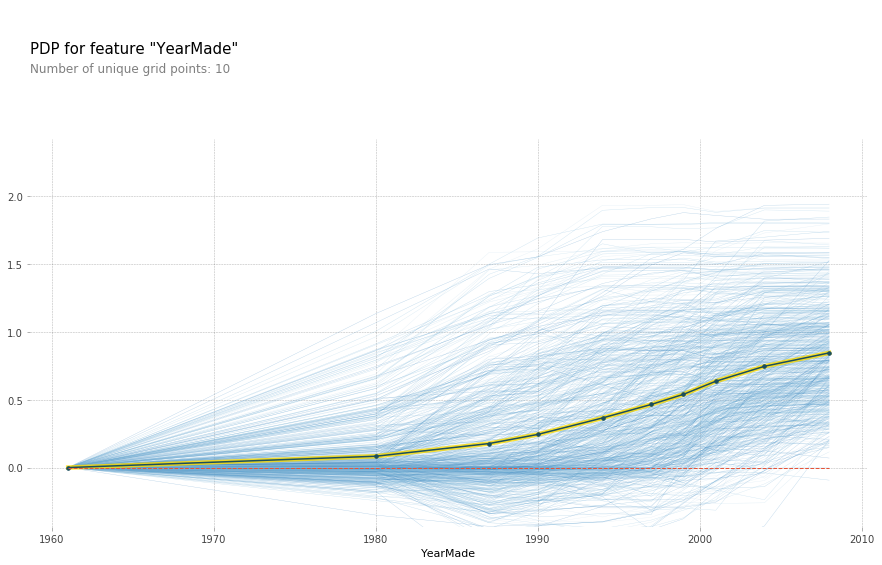

In [103]:
plot_pdp('YearMade')

- This is showing us **for all 500 lines**
- This is like put 1960 for row1,1961 for row1, 1962 for row1...
- Then this is a **single line**
- This is basically a **straight line** for the recent periods.
- Why? Beacuse you would expect newer vehicles to be **MORE EXPENSIVE THAN OLDER MODELS**
- This is using a random forest to get insights about our data.
## STEPS->
- Look at your feature importance to get important variables.
- Then plotting a PDP for knowing what actually is happening.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ecbec9a58>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ecbedc400>})

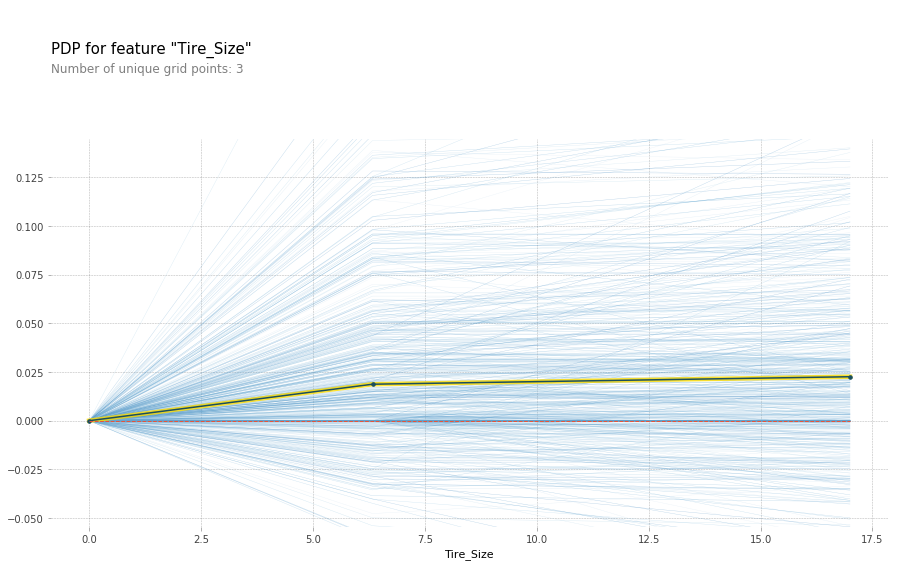

In [108]:
plot_pdp('Tire_Size')

# CLUSTERS->
- It tells us how a bunch of rows move or what is the beahaviour of the rows or the most common shapes that we see.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ec9dfcb70>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ec8ce5518>})

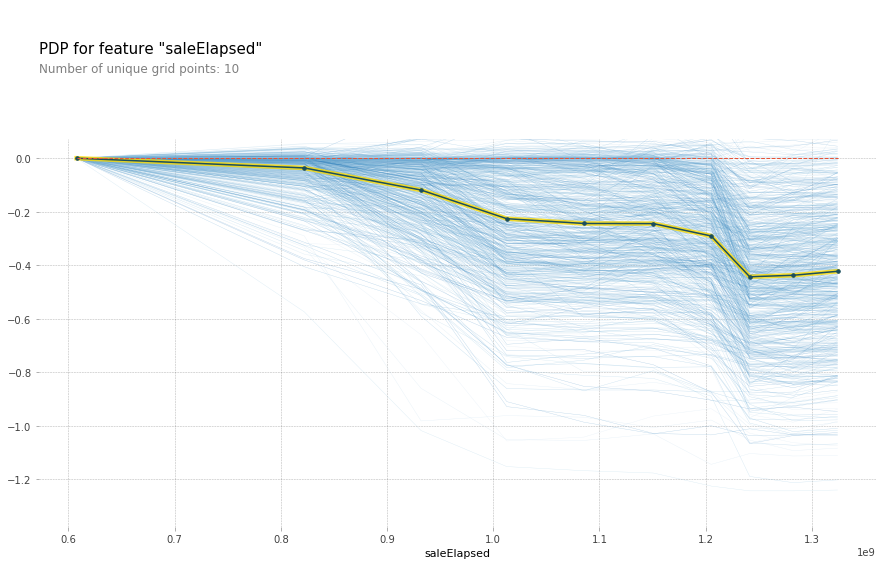

In [121]:
plot_pdp('saleElapsed')

- the above plot means that we have saleElapsed as the independent variable and then you are seeing how the dependent variable behaves as you make each value of the saleElapsed same and then predict the price.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ecb7272e8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1ecb61e5c0>})

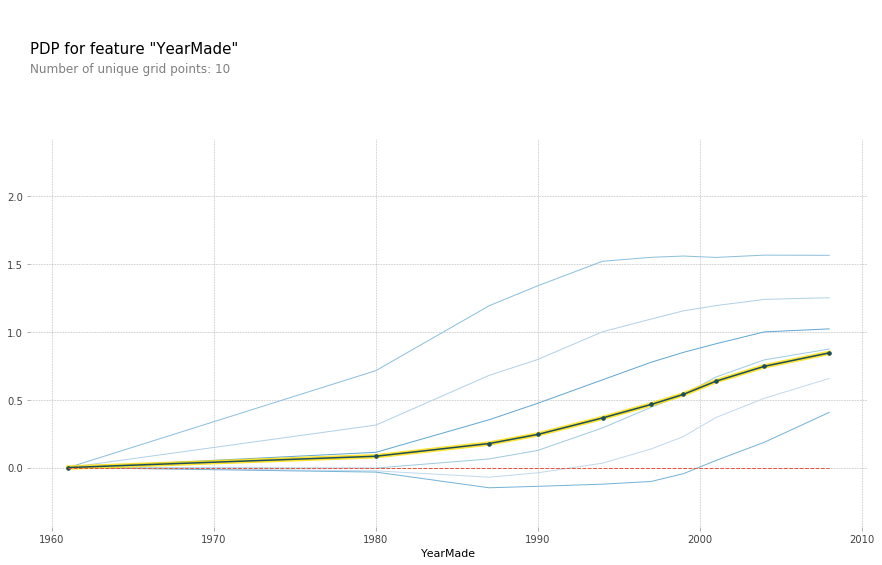

In [109]:
plot_pdp('YearMade',clusters=6)

# This gives you power of interpretation.
- It is not so important for kaggle competitions but feature importance is.
- This is more important for real life analysis.
- **THIS ALLOWS YOU TO SAY HOW A VARIABLE IS DRIVING YOUR DEPENDENT VARIABLE.**

<font size =6>LESSON 5</font>
### - <font color = 'green'> RF tree interpreter,extrapolation and RF from scratch </font>

In [48]:
from IPython.display import Image

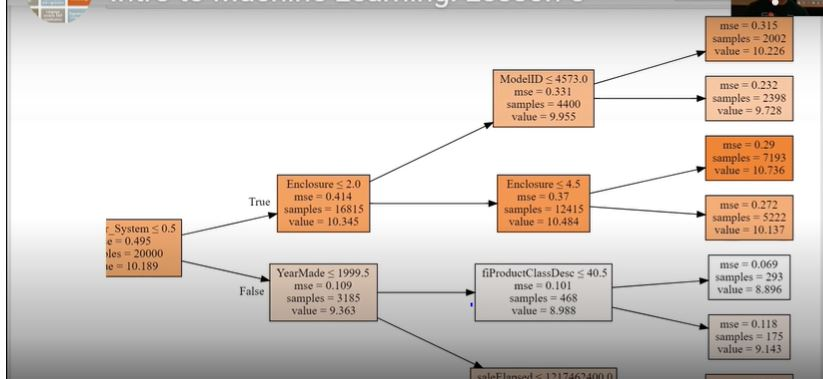

In [49]:
Image("courses/ml1/data/singletree.JPG")

# TREE INTERPRETER
- Suppose we look at a single tree.
- The average of all is 10.189
- Then suppose we go through the branch above.
- It is coupler_system = False and that has average value as 10.345.
- So our change is 10.345 - 10.189.
- Then we have enclosure<2 for which average is 9.955
- Then we have model_id <4573 which gives us value as 10.226 which is the resultant value of the row which went through this ->
coupler - false
enclosure < 2
model_id < 4573
- There are 2002 rows like this and all the predicted values for them were 4573.



# WATERFALL PLOT
- This plot is just a plot of the total average value, then how did the splits affect the value you had originally like what was the change and then what you have is the final value.

In [33]:
from treeinterpreter import treeinterpreter as ti

In [34]:
df_train, df_valid = split_vals(df_raw[df_keep.columns],n_trn)


In [35]:
row = X_valid.values[None,0];row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          1,
              3232,          0,          0,    4364751,          0,       1111,       2010,    2300944,
                 0,         12,          4,          4,         35,        259,         16]])

In [36]:
prediction, bias, contributions = ti.predict(m,row)

- What tree interpreter does is same as the waterfall plots.
## Prediction
- This value shows you what will be the prediction according to your model. You pass in the row through your tree interpreter and it gives you the prediction.
## Bias
- This value if the total average value of the sale prices of the data items. Like here it is 10.10526.
## Contributions
- This gives you back the total of the contributions for each column for each time we see that specific column appear in the tree. Like here in the single tree one it would give you back change values corresponding to the coupler FALSE, enclosure <2, model <4573 .

In [37]:
prediction[0],bias[0]

(array([9.16246]), 10.10561129761686)

In [38]:
contributions[0][0]

0.10774608564414581

In [39]:
ids = np.argsort(contributions[0])
# just getting the order of the rows if they were sorted.

In [40]:
[ i for i in zip(df_keep.columns[ids],df_valid.iloc[0][ids],contributions[0][ids])]

[('ProductSize', 'Mini', -0.5667429075538696),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.13041319034968382),
 ('fiBaseModel', 'KX121', -0.10565288851994122),
 ('fiModelDesc', 'KX1212', -0.07114766619921502),
 ('saleElapsed', 1284595200, -0.06114779627711457),
 ('SalesID', 4364751, -0.0555193993489659),
 ('Enclosure', 'EROPS', -0.049037382039697874),
 ('fiModelDescriptor', nan, -0.038743343503513515),
 ('fiSecondaryDesc', nan, -0.0363245191503732),
 ('saleYear', 2010, -0.02075535561880959),
 ('MachineID', 2300944, -0.020439092535704927),
 ('state', 'Ohio', -0.013328666484186869),
 ('ProductGroup', 'TEX', -0.012393031100918916),
 ('saleDayofyear', 259, -0.0088765776205872),
 ('Drive_System', nan, 0.004677421005830374),
 ('ProductGroupDesc', 'Track Excavators', 0.005981221329698671),
 ('saleDay', 16, 0.010058309024661271),
 ('ModelID', 665, 0.013086079109565097),
 ('Hydraulics_Flow', nan, 0.01838678455266436),
 ('Grouser_Tracks', nan, 0.02101327

In [41]:
list1 = [3,8,1,9,0]
print([list1[i] for i in np.argsort(list1)])

[0, 1, 3, 8, 9]


- NOTE that the total of the **CONTRIBUTIONS** + the bias will give you the prediction for your row.


# <font size=7> EXTRAPOLATION </font>

- A very important part of random forest according to me.
- See, if you have a random forest with a time series right.
- And if you are predicting the next month's price for a **particular item** then can you really predict it for the next month ?
- No, why? Because the random forest has **not seen the sales patterns of the last month** and hence it has no way of **extrapolating the predictions with respect to time**
- This is not really the case in a linear model as it develops a relationship between the time and price and it can **extrapolate your time to predict the price**
- One way to this could be to eliminate time related data or autoincrementing data and use **critical FEATURES of the items** instead of like the sale date or saleyear or something.


<font size = 6> Process</font>
- I want to figure out the **DIFFERENCE BETWEEN OUR TRAINING AND VALIDATION SETS**.
- WHY? So that i can know which predictors are strongly time related components like if both training and validation have id in them right so it is mandatory that **id** of the test would be changed with respect to training always as it would be autoincrement.
- You create a column in the dataframe which is is_valid and fill 1s for the validation set and 0 for the training set.
- So now, you make **is_valid** as the dependent variable and then you can train the random forest according to that.
- Now, if you have a good accuracy then **that means you CAN PREDICT WHETHER A CERTAIN ITEM IS IN VALIDATION SET OR NOT AND HENCE IT HAS A PREDICTOR VARIABLE WHICH IS SURELY GONNA B DIFFERENT IN VALIDATION AND HENCE GIVING THE PREDICTIONS**
- This is really good if you wanna identify the time dependent variables in your test set. If you **can predict whether a certain item is in test set or not** you can then assume that test set is **not a random sample**


- NOTE NOTE NOTE
- After you do figure out the temporal components and try to remove them  one by one.
- How to figure? **feature importance of THIS NEW MODEL**
- Try to remove them one by one and see the scores how they are affected . If they are increased by some amount then **drop them**
- If you do this method correctly you will get a **more generalizable and more robust model which doesn't depend on the external features but on the product features**.

In [72]:
df_keep.to_feather('tmp/bulldozer-keep')


In [73]:
df_keep = feather.read_dataframe('tmp/bulldozer-keep')

In [74]:
df_keep.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'Enclosure', 'fiModelDesc',
       'Grouser_Tracks', 'fiModelDescriptor', 'SalesID', 'Hydraulics_Flow',
       'fiBaseModel', 'saleYear', 'MachineID', 'Drive_System', 'Hydraulics',
       'ProductGroupDesc', 'ProductGroup', 'state', 'saleDayofyear',
       'saleDay'],
      dtype='object')

In [42]:
df_ext = df_keep.copy()

In [43]:
df_ext['is_valid'] = 1
df_ext['is_valid'][:n_trn] = 0
x1 , y1, _ = proc_df(df_ext,'is_valid')

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,oob_score=True)
m.fit(x1,y1)
m.oob_score_ 

0.9999243697914532

- The above score just means that we have a very good predictive power wrt is_valid **which means that validation set and training set have some values that are for sure different for a particular variable**
- How to find out which of them?
- **Feature importance**

In [45]:
fi_new = rf_feat_importance(m,x1)

In [46]:
fi_new[:10]

,cols,imp
11,SalesID,0.795059
5,saleElapsed,0.160668
15,MachineID,0.023685
14,saleYear,0.010514
21,saleDayofyear,0.001975
13,fiBaseModel,0.001930
8,fiModelDesc,0.001496
4,ModelID,0.001495
7,Enclosure,0.000735
1,Coupler_System,0.000655


- The above feature importance means that we are having **SalesID, saleElapsed, machineID, saleyear** all are things that are predictive of our variable **is_valid**


- Let us now calculate score for our model by removing them.

In [47]:
features = ['SalesID','saleElapsed','MachineID']
x1= x1.drop(features,axis = 1)

In [48]:
m.fit(x1,y1)
fi_new = rf_feat_importance(m,x1)
fi_new[:10]

,cols,imp
12,saleYear,0.300172
18,saleDayofyear,0.299157
19,saleDay,0.061907
4,ModelID,0.052031
17,state,0.042814
0,YearMade,0.040674
7,fiModelDesc,0.038158
11,fiBaseModel,0.030181
6,Enclosure,0.024260
14,Hydraulics,0.021322


- Now we get six variables in total and then we build the random forest on the df_keep and look at , by one by one removing our variables, the oob_score and the validation score
- Let us do it.

In [49]:
features.clear()

In [50]:
features = ['SalesID','saleElapsed','MachineID','saleYear','saleDayofyear','ModelID']

In [51]:
features

['SalesID', 'saleElapsed', 'MachineID', 'saleYear', 'saleDayofyear', 'ModelID']

In [59]:
X_train, X_valid = split_vals(df_keep,n_trn)
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.20736592072524088, 0.2458590343705888, 0.9101310650504141, 0.8920505790413827, 0.8938694435342402]


In [57]:
set_rf_samples(50000)

- In the below code we are just removing the columns one by one and then seeing is the score getting **better** or is it getting **worse**.
- So, we take each column, split the values amongst the training and valiadtion and then train the model according to the **newly formed datasets**

In [60]:
for f in features:
    df_other= df_keep.drop(f,axis =1)
    X_train, X_valid = split_vals(df_other,n_trn)
    m = RandomForestRegressor(n_jobs = -1, n_estimators=40,max_features=0.5,min_samples_leaf=3,oob_score=True)
    print(f,"dropped.\nScore is:")
    m.fit(X_train,y_train)
    print_score(m)
    

SalesID dropped.
Score is:
[0.20798890631598807, 0.24410664474304922, 0.9095902707698139, 0.8935839396694556, 0.8936245348385855]
saleElapsed dropped.
Score is:
[0.20996405633577692, 0.24661899977815063, 0.9078649799097106, 0.8913821910125312, 0.8913846365051317]
MachineID dropped.
Score is:
[0.20567031809194838, 0.24222365991075, 0.9115947481751476, 0.8952193477086147, 0.8961013603838494]
saleYear dropped.
Score is:
[0.20816124078456588, 0.2467264166709636, 0.9094403861647742, 0.8912875516824844, 0.892915929810184]
saleDayofyear dropped.
Score is:
[0.20781654468045577, 0.24491225340688516, 0.9097400548341857, 0.8928803851698879, 0.8937944234047428]
ModelID dropped.
Score is:
[0.2082649911651163, 0.24909529077842532, 0.9093500913932, 0.8891899863743241, 0.89288943219859]


In [63]:
df_keep=df_keep.drop(['SalesID','MachineID','saleDayofyear'],axis=1)

In [64]:
reset_rf_samples()

# FINALLY THE MODEL IS DONE.

In [66]:
X_train,X_valid = split_vals(df_keep,n_trn)
m =RandomForestRegressor(n_estimators=140,min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.13545301748826977, 0.21572816611434886, 0.9616546951683944, 0.9168883934785698, 0.9145764196921996]


# wah!